# M1. Actividad 5.  Parallel Data Processing in Apache Spark (using Pyspark)

Integrantes:

A01752114 | Antonio Oviedo Paredes

A01752057 | Raul Alejandro Olivares Maldonado

A01752113 | Rodrigo Mejía Jiménez

A01751559 | Alex Federico Núñez Escobar

A01745482 | Natalia Duarte Corzo

A01751654 | Diego Fernando Landeros Austria

A01745446 | Sergio Manuel González Vargas




## 1.1 Configuración de PySpark

###Paso 1: Configuración del entorno de PySpark en Colab

In [ ]:
#Bibliotecas para poder trabajar con Spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

!tar xf spark-3.5.0-bin-hadoop3.tgz

#Configuración de Spark con Python
!pip install -q findspark
!pip install pyspark

#Estableciendo variable de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

#Buscando e inicializando la instalación de Spark
import findspark
findspark.init()
findspark.find()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,192 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,463 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,274 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadconten

'/content/spark-3.5.0-bin-hadoop3'

###Paso 2: Crear la sesión de trabajo de Spark

In [ ]:
# Configuración de Spark con Python
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

# Configurar la memoria del ejecutor y del driver de Spark
conf = SparkConf()
conf.setMaster("local[*]") \
    .setAppName("MatrixMultiplication") \
    .set("spark.executor.memory", "16g") \
    .set("spark.driver.memory", "16g") \
    .set("spark.driver.maxResultSize", "8g")

# Creación de un SparkContext
sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Parte 2. Parallel and Sequential Matrix multiplication

In [ ]:
# +======================================================================+
# |                                                                      |
# | File: matrix_multiply.py                                             |
# | Author: Jim Kelly | N9763686                                         |
# | Purposes: This script has been created for the purposes of an        |
# |      oral presentation for CAB401 High Performance and Parallel      |
# |      Computing, Semester 2, 2021, at the Queensland University of    |
# |      Technology (QUT). The script demonstrates a basic comparison    |
# |      between the best sequential matrix multiplication with Python   |
# |      and the parallelised implementation of matrix multiplication    |
# |      using Apache-Spark's BlockMatrix.                               |
# | Description: To change the matrix dimensions replace the value for   |
# |      'N'. The script will first calculate the sequential values of   |
# |      of two matrices populated with number N randomised values. The  |
# |      script will then compute the same operation using Spark's       |
# |      parallelisation methods, i.e. BlockMatrix.multiply().           |
# +======================================================================+
# | References:                                                          |
# | as_block_matrix: Taken from Stack Overflow,                          |
# |     How to Multiply Two Numpy Matrices in PySpark?,                  |
# | 'https://stackoverflow.com/questions/42889965/multiply-two-numpy-    |
# |     matrices-in-pyspark'                                             |
# | indexrowmatrix_to_array: Taken from Stack Overflow,                  |
# |     How to Convert a DistributedMatrix to Scipy Sparse or            |
# |         Numpy Array,                                                 |
# | 'https://stackoverflow.com/questions/54083978/convert-a-             |
# |     distributedmatrix-to-scipy-sparse-or-numpy-array'                |
# +======================================================================+
# |                           Imports                                    |
# +======================================================================+

import random
from timeit import default_timer as timer
from scipy.sparse import lil_matrix
from pyspark.sql import SparkSession
from pyspark.mllib.linalg.distributed import *

### 2.1 Creación de Matrices y pruebas con distintos N

In [54]:
# Create and start Spark session
app_name = 'PySpark Matrix Multiplication Example'
master = 'local'
spark = SparkSession.builder.appName(app_name).master(master).getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

def create_matrix(size, max_value):
    return [[random.randint((max_value * -1), max_value) for i in range(size)] \
            for j in range(size)]

# Method to create a matrix populated with 0's of size N * N.
def create_empty_matrix(size):
    return [[0 for i in range(size)] for j in range(size)]

# Method to multiply two matrices of the same dimensions, i.e. N * N.
def matrix_multiply(A, B, C, size):
    for i in range(size):
        for j in range(size):
            total = 0 # Initialise total to 0
            for k in range(size):
                total += A[i][k] * B[k][j] # Perform matrix multiply
            C[i][j] = total

    # Return the result of the matrix multiplication
    return C

# Method to convert a Resilient Distributed Dataset (RDD) to a BlockMatrix object
def as_block_matrix(rdd, rows, columns):
    return IndexedRowMatrix(
        rdd.zipWithIndex().map(lambda i: IndexedRow(i[1], i[0]))
    ).toBlockMatrix(rows, columns)

# Method to convert an indexed row matrix to a local array using Scipy 'lil_matrix'
def indexedrowmatrix_to_array(matrix):
    # Create an empty array of the same dimensions as the matrix
    result = lil_matrix((matrix.numRows(), matrix.numCols()))

    # Iterate through each row and set values in the empty array
    for indexed_row in matrix.rows.collect():
        result[indexed_row.index] = indexed_row.vector

    # Return the local array
    return result


# Define global variables
M = [i for i in range(50, 900, 50)]
sequential_records = []
parallel_records = []
time_difference = []

# Loop through different matrix sizes
for N in M:
    # Initialise matrices
    A = create_matrix(N, 500)
    B = create_matrix(N, 500)
    C = create_empty_matrix(N)

    # Measure sequential matrix multiplication time
    start = timer()
    C = matrix_multiply(A, B, C, N)
    end = timer()

    sequential_time = end - start
    sequential_records.append(sequential_time)

    # Convert matrices to RDDs
    A_rdd = spark.sparkContext.parallelize(A)
    B_rdd = spark.sparkContext.parallelize(B)

    # Measure parallel matrix multiplication time
    start = timer()
    C_matrix = as_block_matrix(A_rdd, N, N).multiply(as_block_matrix(B_rdd, N, N))
    end = timer()

    parallel_time = end - start
    parallel_records.append(parallel_time)

    time_difference.append(abs(sequential_time - parallel_time))

# Print results
print('Runs:\n')
for i in range(len(M)):
    print("N =", M[i], ":")
    print("\tSequential: ")
    print("\t", sequential_records[i])
    print("\tParallel: ")
    print("\t", parallel_records[i])

# Find the most similar running time
min_diff_i = time_difference.index(min(time_difference))
print('\nMost similar running time: \n\tN: ', M[min_diff_i], " \n\tDifference: ", time_difference[min_diff_i])

Runs:

N = 50 :
	Sequential: 
	 0.02041729799930181
	Parallel: 
	 7.494674128000042
N = 100 :
	Sequential: 
	 0.16481047500019486
	Parallel: 
	 5.122095451999485
N = 150 :
	Sequential: 
	 0.5608196600005613
	Parallel: 
	 6.922892504999254
N = 200 :
	Sequential: 
	 1.4000571010001295
	Parallel: 
	 5.556617927000843
N = 250 :
	Sequential: 
	 4.363779166998938
	Parallel: 
	 6.4448546650000935
N = 300 :
	Sequential: 
	 7.057635226999992
	Parallel: 
	 6.495027012999344
N = 350 :
	Sequential: 
	 10.999567528000625
	Parallel: 
	 9.03180308300034
N = 400 :
	Sequential: 
	 16.355785719999403
	Parallel: 
	 9.4584957449988
N = 450 :
	Sequential: 
	 22.884654485998908
	Parallel: 
	 8.959563018999688
N = 500 :
	Sequential: 
	 34.51021946899891
	Parallel: 
	 8.482373099999677
N = 550 :
	Sequential: 
	 44.36620469099944
	Parallel: 
	 9.650348404000397
N = 600 :
	Sequential: 
	 56.493541726998956
	Parallel: 
	 10.243155100999502
N = 650 :
	Sequential: 
	 70.9127042379987
	Parallel: 
	 11.3617898840002

### 2.2 Ejecución paralela aproximada a 5 minutos

In [ ]:
# Define global variables
N = 5275 # Matrix dimensions
# Initialise matrices
A = create_matrix(N, 500)
B = create_matrix(N, 500)
C = create_empty_matrix(N)

# Convert arrays to RDDs
A_rdd = spark.sparkContext.parallelize(A)
B_rdd = spark.sparkContext.parallelize(B)

# Perform and time matrix multiplication
start = timer()
C_matrix = as_block_matrix(A_rdd, N, N).multiply(as_block_matrix(B_rdd, N, N)) #
end = timer()

# Print the execution time
print('N: ',N,'\nApache Spark execution time (minutes):', (end - start)/60)


N:  5275 
Apache Spark execution time (minutes): 5.485085715949996


### 2.3 Graficación de las curvas

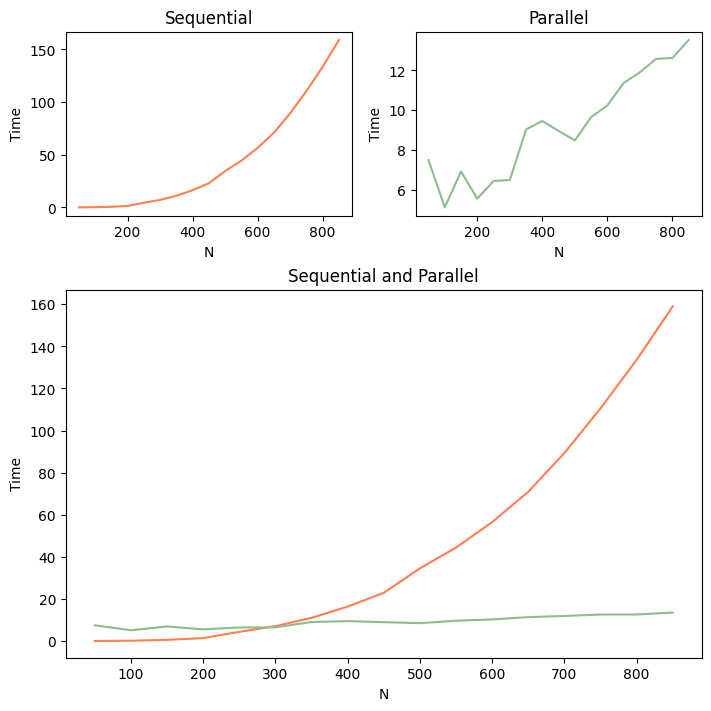

In [55]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7), layout='constrained')
axs = fig.subplot_mosaic([["sequential", "parallel"],
                          ["par_seq", "par_seq"],
                          ["par_seq", "par_seq"]])

# Sequential plot
axs["sequential"].set_title("Sequential")
axs["sequential"].plot(M, sequential_records, color='coral')
axs["sequential"].set_xlabel("N")
axs["sequential"].set_ylabel("Time")

# Parallel plot
axs["parallel"].set_title("Parallel")
axs["parallel"].plot(M, parallel_records, color='darkseagreen')
axs["parallel"].set_xlabel("N")
axs["parallel"].set_ylabel("Time")

# Sequential and parallel plot
axs["par_seq"].set_title("Sequential and Parallel")
axs["par_seq"].plot(M, sequential_records, color='coral')
axs["par_seq"].plot(M, parallel_records, color='darkseagreen')
axs["par_seq"].set_xlabel("N")
axs["par_seq"].set_ylabel("Time")

plt.show()


### 2.3 Pregunta abierta
¿Es posible estimar la función fs y fp, tal que Ts = fs(N), y Tp = fp(N) ? Ts y Tp son los tiempos de ejecución para la versión secuencial y paralela, respetivamente.

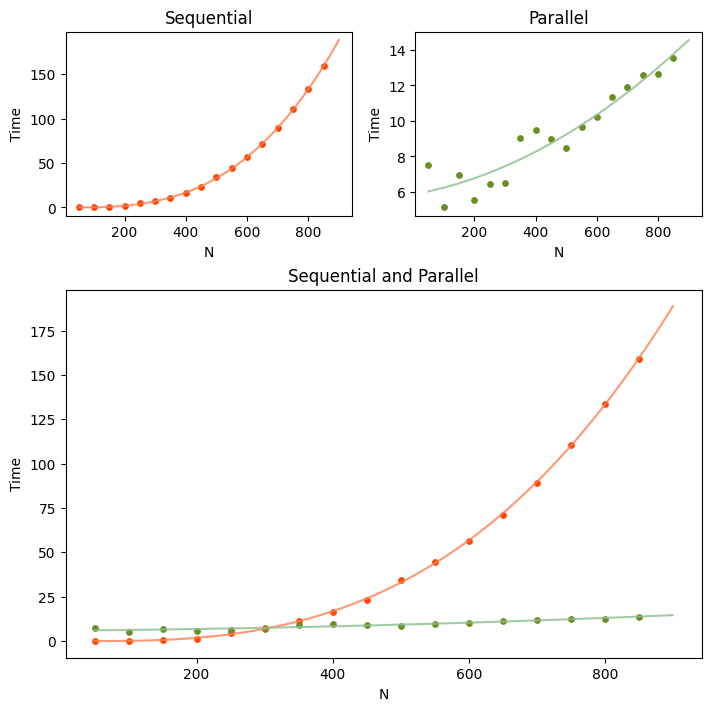

In [56]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Quadratic regression for sequential and parallel process
x = np.array(M)  # Input data
sequential_y = np.array(sequential_records)  # Sequential process time data
parallel_y = np.array(parallel_records)  # Parallel process time data

# Create polynomial features for degree 3
poly_3 = PolynomialFeatures(degree=3)
X_3 = poly_3.fit_transform(x.reshape(-1, 1))

# Create polynomial features for degree 2
poly_2 = PolynomialFeatures(degree=2)
X_2 = poly_2.fit_transform(x.reshape(-1, 1))

# Fit linear regression models for sequential and parallel data
seq_poly_reg = LinearRegression().fit(X_3, sequential_y)
par_poly_reg = LinearRegression().fit(X_2, parallel_y)

# Extract coefficients for the cubic equation in sequential regression
seq_a = seq_poly_reg.coef_[3]
seq_b = seq_poly_reg.coef_[2]
seq_c = seq_poly_reg.coef_[1]
seq_d = seq_poly_reg.intercept_

# Extract coefficients for the quadratic equation in parallel regression
par_a = par_poly_reg.coef_[2]
par_b = par_poly_reg.coef_[1]
par_c = par_poly_reg.intercept_

# Generate x values for the polynomial regression curves
poly_reg_x = np.linspace(50, 900, 100)

# Calculate y values for the sequential and parallel regression curves
seq_poly_reg_y = seq_a * poly_reg_x**3 + seq_b * poly_reg_x**2 + seq_c * poly_reg_x + seq_d
par_poly_reg_y = par_a * poly_reg_x**2 + par_b * poly_reg_x + par_c

# Create a figure and subplots for the three plots
fig = plt.figure(figsize=(7, 7), layout='constrained')
axs = fig.subplot_mosaic([["sequential", "parallel"],
                          ["par_seq", "par_seq"],
                          ["par_seq", "par_seq"]])

# Sequential plot
axs["sequential"].set_title("Sequential")
axs["sequential"].scatter(M, sequential_records, color='orangered', s=15)
axs["sequential"].plot(poly_reg_x, seq_poly_reg_y, color='coral', alpha=0.8)
axs["sequential"].set_xlabel("N")
axs["sequential"].set_ylabel("Time")

# Parallel plot
axs["parallel"].set_title("Parallel")
axs["parallel"].scatter(M, parallel_records, color='olivedrab', s=15)
axs["parallel"].plot(poly_reg_x, par_poly_reg_y, color='darkseagreen', alpha=0.8)
axs["parallel"].set_xlabel("N")
axs["parallel"].set_ylabel("Time")

# Sequential and parallel plot
axs["par_seq"].set_title("Sequential and Parallel")
axs["par_seq"].scatter(M, sequential_records, color='orangered', s=15)
axs["par_seq"].plot(poly_reg_x, seq_poly_reg_y, color='coral', alpha=0.8)
axs["par_seq"].scatter(M, parallel_records, color='olivedrab', s=15)
axs["par_seq"].plot(poly_reg_x, par_poly_reg_y, color='darkseagreen', alpha=0.8)
axs["par_seq"].set_xlabel("N")
axs["par_seq"].set_ylabel("Time")

# Display the plots
plt.show()

Sí, es posible estimar las funciones fs(N) y fp(N). En el código se utilizan regresiones polinomiales de grado 3 para fs(N) y grado 2 para fp(N). Estas regresiones intentan modelar la relación entre el tamaño de la entrada N y el tiempo de ejecución para las versiones secuencial y paralela del algoritmo de multiplicación de matrices.

Es importante tener en cuenta que la calidad del ajuste de la regresión polinomial depende de la naturaleza de los datos y de la relación entre las variables. En este caso, la curva de la versión paralela no se ajusta muy bien debido a la falta de una tendencia clara en los puntos, posiblemente debido a la complejidad e incertidumbre del proceso de paralelización que realiza la biblioteca de pyspark.

El excelente ajuste de la versión secuencial a la curva polinómica se debe al hecho de que el algoritmo secuencial de multiplicación de matrices tiene una complejidad temporal de O(n^3). Esta complejidad cúbica permite un modelado directo con un polinomio de grado 3, ya que el polinomio captura el crecimiento cúbico en el tiempo de ejecución con respecto al tamaño de la entrada N. Esto contrasta con la versión paralela, donde la paralelización puede dar lugar a una relación menos evidente y más difícil de modelar entre N y el tiempo de ejecución.

En resumen, aunque es posible estimar las funciones fs(N) y fp(N), la calidad del ajuste y la interpretación de los resultados deben considerarse cuidadosamente, especialmente cuando se trata de procesos de paralelización. Es importante tener en cuenta que el rendimiento de la versión paralela puede no seguir una tendencia fácilmente modelable, mientras que la versión secuencial puede ser satisfactoriamente representada mediante un modelo polinómico de grado 3.